# Diffusion unet using tinyai

## Setup

In [2]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import  torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *

In [3]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

In [6]:
sig_data = 0.66

In [7]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

def scalings(sig):
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [8]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

## Train

Based on Diffusers

In [9]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [10]:
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.convs = nn.Sequential(unet_conv(ni, nf, ks, act=act, norm=norm),
                                   unet_conv(nf, nf, ks, act=act, norm=norm))
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.convs(x) + self.idconv(x)

The disign pattern bellow is called `mixin`

In [11]:
class A:
    def __call__(self):
        super().__call__()
        print('a')

class B:
    def __call__(self): print('b')

class C(A,B): pass

In [12]:
C()()

b
a


In [13]:
class D(B,A): pass
D()()

b


In [14]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.saved = super().forward(x, *args, **kwargs)
        return self.saved

class SavedResBlock(SaveModule, UnetResBlock): pass
class SavedConv(SaveModule, nn.Conv2d): pass

In [15]:
def down_block(ni, nf, add_down=True, num_layers=1):
    res = nn.Sequential(*[SavedResBlock(ni=ni if i==0 else nf, nf=nf)
                         for i in range(num_layers)])
    if add_down: res.append(SavedConv(nf, nf, 3, stride=2, padding=1))
    return res

In [16]:
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [34]:
class UpBlock(nn.Module):
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [UnetResBlock((prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1))
        return self.up(x)

The number of filters is derived from the unconditional stable diffusion model.

In [35]:
class UNet2DModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        nf = nfs[0]
        self.downs = nn.Sequential()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(down_block(ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        
        self.mid_block = UnetResBlock(nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d)

    def forward(self, inp):
        x = self.conv_in(inp[0])
        saved = [x]
        x = self.downs(x)
        saved += [p.saved for o in self.downs for p in o]
        x = self.mid_block(x)
        for block in self.ups: x = block(x, saved)
        return self.conv_out(x)

Its not the same as diffusers unconditional model since we dont use attenction.

Here we reduce the number of channels and filters since we are using FashionMNIST.

In [36]:
model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [37]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.508,0,train
0.342,0,eval
0.249,1,train
0.247,1,eval
0.209,2,train
0.223,2,eval
0.194,3,train
0.245,3,eval
0.187,4,train
0.279,4,eval


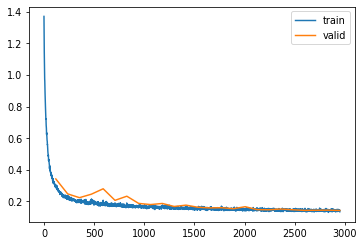

In [23]:
learn.fit(epochs)

## Timesteps

In [38]:
emb_dim = 16
tsteps = torch.linspace(-10,10,100)
max_period = 10000

In [39]:
math.log(10000)

9.210340371976184

In [40]:
exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)

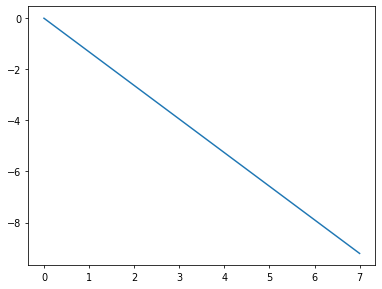

In [41]:
plt.plot(exponent);

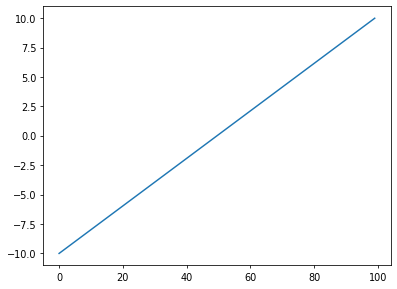

In [42]:
plt.plot(tsteps);

In [43]:
emb = tsteps[:,None].float() * exponent.exp()[None,:]
emb.shape

torch.Size([100, 8])

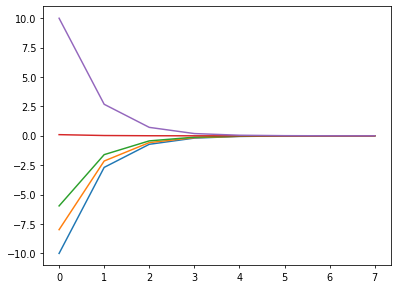

In [44]:
plt.plot(emb[0])
plt.plot(emb[10])
plt.plot(emb[20])
plt.plot(emb[50])
plt.plot(emb[-1]);

In [45]:
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
emb.shape

torch.Size([100, 16])

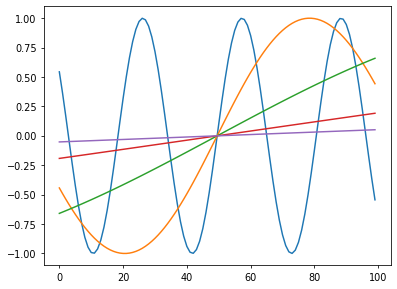

In [46]:
plt.plot(emb[:,0])
plt.plot(emb[:,1])
plt.plot(emb[:,2])
plt.plot(emb[:,3])
plt.plot(emb[:,4]);

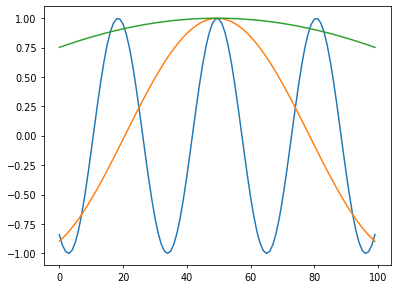

In [47]:
plt.plot(emb[:,8])
plt.plot(emb[:,9])
plt.plot(emb[:,10]);

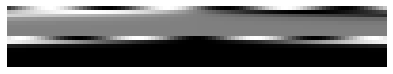

In [48]:
show_image(emb.T, figsize=(7,7));

In [49]:
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

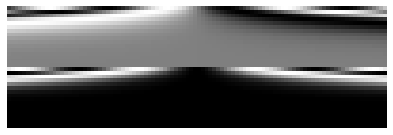

In [50]:
show_image(timestep_embedding(tsteps, 32, max_period=1000).T, figsize=(7,7));

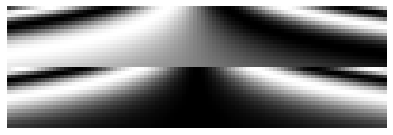

In [51]:
show_image(timestep_embedding(tsteps, 32, max_period=10).T, figsize=(7,7));

## Timestep model

In [52]:
from functools import wraps

In [32]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

#### Embeding ResBlock 
We not only parse the activations to the ResBlock but TimeEmbeding as well

In [33]:
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = unet_conv(ni, nf, ks, act=act, norm=norm) #, bias=not norm)
        self.conv2 = unet_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        return x + self.idconv(inp)

In [53]:
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

In [54]:
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [55]:
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

In [56]:
class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        # TODO: remove act func from 1st MLP layer
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [44]:
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [45]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.399,0,train
0.259,0,eval
0.218,1,train
0.234,1,eval
0.194,2,train
0.205,2,eval
0.180,3,train
0.209,3,eval
0.173,4,train
0.214,4,eval


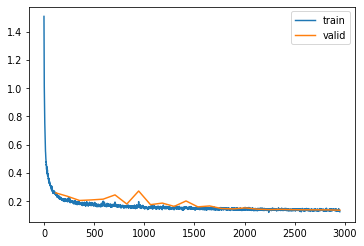

In [46]:
learn.fit(epochs)

## Sampling

In [49]:
from tinyai.fid import ImageEval

In [62]:
from scipy import integrate

In [50]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 2048
tds2 = dsd.with_transform(transformi)
dls2 = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls2.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [51]:
sz = (512,1,32,32)

In [52]:
sz = (2048,1,32,32)

In [53]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7.):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).cuda()

def denoise(model, x, sig):
    sig = sig[None] #* torch.ones((len(x),1), device=x.device)
    c_skip,c_out,c_in = scalings(sig)
    return model((x*c_in, sig))*c_out + x*c_skip

In [54]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to,var_from = sigma_to**2,sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to-sigma_up**2)**0.5, sigma_up

@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

In [58]:
@torch.no_grad()
def sample_euler(x, sigs, i, model):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    return x + (x-denoised)/sig*(sig2-sig)

@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt

In [59]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).cuda()*sigma_max
    sigs = sigmas_karras(steps, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds

In [60]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).cuda()*sigma_max
    sigs = sigmas_karras(steps, sigma_max=sigma_max)
    for i in progress_bar(range(len(sigs)-1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

In [68]:
# preds = sample_lms(model, steps=20, order=3)
preds = sample(sample_euler_ancestral, model, steps=100, eta=1.)
# preds = sample(sample_euler, model, steps=100)
# preds = sample(sample_heun, model, steps=20, s_churn=0.5)

In [69]:
s = preds[-1]
s.min(),s.max()

(tensor(-1.05335, device='cuda:0'), tensor(1.51649, device='cuda:0'))

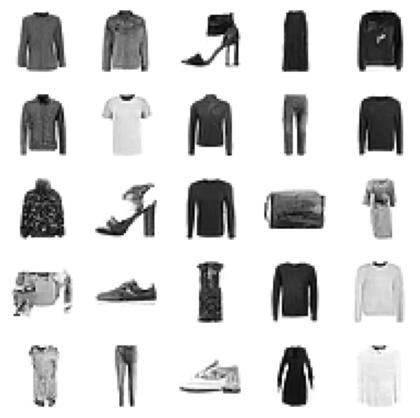

In [70]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [71]:
ie.fid(s),ie.kid(s),s.shape

(4.6273193359375, 0.014942983165383339, torch.Size([2048, 1, 32, 32]))

In [72]:
preds = sample_lms(model, steps=20, order=3)
s = preds[-1]
ie.fid(s),ie.kid(s),s.shape

(9.009033203125, 0.02908358909189701, torch.Size([2048, 1, 32, 32]))